[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

Deploying large deep neural network models is a challenge, especially when edge devices with limited memory and computational power are in the equation. To overcome this challenge, the “Knowledge Distillation” technique arose as a form of model compression. This method focuses on the process of transferring knowledge from a large model to a smaller model that can be practically deployed under real-world constraints. It was first successfully demonstrated by Bucilua et al., (2006) [1] and then, popularized by Hinton et al., (2015) [2]. The real challenge is to implement this mechanism without a significant loss in performance. In the case of current SOTA neural networks, knowledge distillation has arisen as a possibility to compress all those millions of weights and tens of processing layers. In this notebook, this technique is implemented. We have used this example as a source: https://www.kaggle.com/code/pdochannel/efficientnet-distillation-b3-b0-butterfly-75

In [1]:
!pip install -q timm

In [79]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch import optim, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

import timm
from timm.loss import LabelSmoothingCrossEntropy

import warnings
warnings.filterwarnings("ignore")

import sys
from tqdm import tqdm
import time
import copy
import shutil

from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def create_basic_file_structure():
    '''
    It creates the basic folder structure to further use PyTorch Data loader functionalities.
    '''
    if os.path.exists(ROOT_FOLDER_NAME):
        print("Directory " , ROOT_FOLDER_NAME ,  " already exists. Deleting...")
        shutil.rmtree(ROOT_FOLDER_NAME)
    os.makedirs(ROOT_FOLDER_NAME)
    os.makedirs(ROOT_FOLDER_NAME + os.path.sep + TRAIN_FOLDER_NAME)
    os.makedirs(ROOT_FOLDER_NAME + os.path.sep + VALIDATION_FOLDER_NAME)
    print("Directories Created ")


def create_complete_file_structure():
    '''
    It creates the basic folder structure to further use PyTorch Data loader functionalities.
    Moreover, given the folder where the datasets are stores, it creates a train-validation split
    of the data.
    WARNING: Modify the experimental constants provided below to create a different file structure.
    '''
    TRAIN_VAL_SPLIT = 0.75
    
    create_basic_file_structure()
    for dataset_foder_name in DATASET_FOLDER_NAMES:
        print(f"Copying: {dataset_foder_name}")
        print(dataset_foder_name.split("-")[0])
        label_name = dataset_foder_name.split("-")[0]
        new_image_train_path = ROOT_FOLDER_NAME + os.path.sep + \
                                TRAIN_FOLDER_NAME + os.path.sep + label_name
        new_image_val_path = ROOT_FOLDER_NAME + os.path.sep + \
                                VALIDATION_FOLDER_NAME + os.path.sep + label_name
        os.makedirs(new_image_train_path)
        os.makedirs(new_image_val_path)
        original_complete_folder_path = ORIGINAL_DATASETS_FOLDER + os.path.sep + \
                                            dataset_foder_name
        original_images_files = os.listdir(original_complete_folder_path)
        len_dataset = len(original_images_files)
        print(f"Number of copied images:{len_dataset}")
        for image_file in original_images_files[:int(len_dataset*TRAIN_VAL_SPLIT)]:
            shutil.copyfile(original_complete_folder_path + os.path.sep + image_file, 
                            new_image_train_path + os.path.sep + image_file)
        for image_file in original_images_files[int(len_dataset*TRAIN_VAL_SPLIT):]:
            shutil.copyfile(original_complete_folder_path + os.path.sep + image_file, 
                            new_image_val_path + os.path.sep + image_file)

In [83]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            #T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            #T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=1)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
        return val_loader, test_loader, len(val_data), len(test_data)

def set_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    n_inputs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(n_inputs, 512),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(512, len(classes))
    )

    model = model.to(device)
    return model

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print(os.path.getsize("temp.p")/1e6)
    os.remove("temp.p")

In [72]:
def train_teacher(teacher, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(teacher.state_dict())
    best_acc = 0.0

    criterion = LabelSmoothingCrossEntropy()
    criterion = criterion.to(device)
    optimizer = optim.AdamW(teacher.classifier.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                teacher.train() # model to training mode
            else:
                teacher.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(data_loaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                ## Supposedly faster than optimizer.zero_grad() ##
                #for param in teacher.parameters():
                #    param.grad = None
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    teacher_preds = teacher(inputs)
                    
                    _, preds = torch.max(teacher_preds, 1) # used for accuracy
                    
                    loss = criterion(teacher_preds, labels)
                    
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(teacher.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    teacher.load_state_dict(best_model_wts)
    return teacher

In [73]:
BATCH_SIZE = 16
DATASET_PATH = "./pytorch_eden_data"
NUM_WORKERS = 2

ROOT_FOLDER_NAME = "pytorch_eden_data"
ORIGINAL_DATASETS_FOLDER = os.path.dirname(os.getcwd()) + os.path.sep + \
                            "eden_library_datasets"
TRAIN_FOLDER_NAME = "train"
VALIDATION_FOLDER_NAME = "val"
DATASET_FOLDER_NAMES = ["Black nightsade-Solanum nigrum-220519-Weed-zz",
                        "Cotton-Gossypium herbaceum-100619-Healthy-zz",
                        #"Tomato-Solanum lycopersicum-240519-Healthy-zz",
                        "Velvet leaf-Abutilon theophrasti-220519-Weed-zz"]

EPOCHS_TEACHER = 5
EPOCHS_DISTILLATION = 5

In [74]:
create_complete_file_structure()

Directory  pytorch_eden_data  already exists. Deleting...
Directories Created 
Copying: Black nightsade-Solanum nigrum-220519-Weed-zz
Black nightsade
Number of copied images:124
Copying: Cotton-Gossypium herbaceum-100619-Healthy-zz
Cotton
Number of copied images:47
Copying: Velvet leaf-Abutilon theophrasti-220519-Weed-zz
Velvet leaf
Number of copied images:121


In [75]:
classes = get_classes(os.path.join(DATASET_PATH, "train"))
print(classes, len(classes))

['Black nightsade', 'Cotton', 'Velvet leaf'] 3


In [84]:
(train_loader, train_data_len) = get_data_loaders(DATASET_PATH, BATCH_SIZE, train=True)
(val_loader, test_loader, val_data_len, test_data_len) = get_data_loaders(DATASET_PATH, BATCH_SIZE, train=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


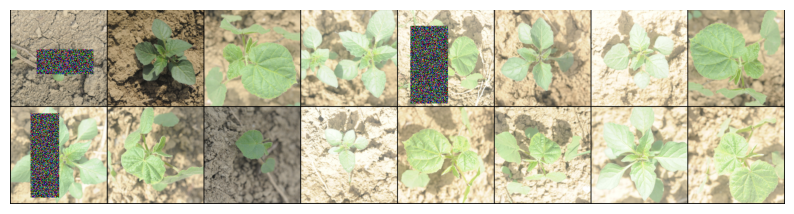

In [85]:
images_batch = next(iter(train_loader))
grid = make_grid(images_batch[0])
plt.figure(figsize=(10, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.show()

In [54]:
data_loaders = {
    'train': train_loader,
    "val": val_loader,
}

dataset_sizes = {
    "train": train_data_len,
    "val": val_data_len
}

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [56]:
teacher = timm.create_model("efficientnet_b3", pretrained=True)
student = timm.create_model("efficientnet_b0", pretrained=True)

#### Creating the Teacher and the Student

In [57]:
teacher = set_model(teacher)
student = set_model(student)

In [58]:
teacher_ft = train_teacher(teacher, num_epochs=EPOCHS_TEACHER)

Epoch 0/4
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.37s/it]


train Loss: 0.8485 Acc: 0.6422


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.12s/it]


val Loss: 0.5970 Acc: 0.9722

Epoch 1/4
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.46s/it]


train Loss: 0.5660 Acc: 0.8761


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.13s/it]


val Loss: 0.4329 Acc: 0.9583

Epoch 2/4
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.42s/it]


train Loss: 0.4691 Acc: 0.9128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]


val Loss: 0.3680 Acc: 0.9722

Epoch 3/4
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.41s/it]


train Loss: 0.4938 Acc: 0.8853


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.08s/it]


val Loss: 0.3990 Acc: 0.9722

Epoch 4/4
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.40s/it]


train Loss: 0.4169 Acc: 0.9587


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.08s/it]

val Loss: 0.3901 Acc: 1.0000

Training complete in 3m 42s
Best Val Acc: 1.0000


In [59]:
def distill_model(teacher, student, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(student.state_dict())
    best_acc = 0.0
    temp=7
    alpha=0.3
    teacher.eval()

    criterion = LabelSmoothingCrossEntropy()
    divergence_loss_fn = nn.KLDivLoss(reduction="batchmean")
    criterion = criterion.to(device)
    divergence_loss_fn = divergence_loss_fn.to(device)
    optimizer = optim.AdamW(student.classifier.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                student.train() # model to training mode
            else:
                student.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(data_loaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                ## Supposedly faster than optimizer.zero_grad() ##
                for param in student.parameters():
                    param.grad = None
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    teacher_preds = teacher(inputs)
                    student_preds = student(inputs)
                    
                    _, preds = torch.max(student_preds, 1) # used for accuracy
                    
                    student_loss = criterion(student_preds, labels)
                    ditillation_loss = divergence_loss_fn(
                        F.softmax(student_preds / temp, dim=1),
                        F.softmax(teacher_preds / temp, dim=1)
                    )
                    
                    loss = alpha * student_loss + (1 - alpha) * ditillation_loss
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(student.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    student.load_state_dict(best_model_wts)
    return student

In [60]:
student_ft = distill_model(teacher_ft, student, num_epochs=EPOCHS_DISTILLATION)

Epoch 0/4
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.39s/it]


train Loss: -0.7472 Acc: 0.6697


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.08s/it]


val Loss: -0.8207 Acc: 0.9028

Epoch 1/4
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.40s/it]


train Loss: -0.8459 Acc: 0.9128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.10s/it]


val Loss: -0.8547 Acc: 0.9306

Epoch 2/4
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.41s/it]


train Loss: -0.8688 Acc: 0.9587


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.06s/it]


val Loss: -0.8681 Acc: 0.9306

Epoch 3/4
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.39s/it]


train Loss: -0.8472 Acc: 0.8991


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.12s/it]


val Loss: -0.8568 Acc: 0.9306

Epoch 4/4
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.41s/it]


train Loss: -0.8809 Acc: 0.9817


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.05s/it]

val Loss: -0.8753 Acc: 0.9306

Training complete in 3m 40s
Best Val Acc: 0.9306


## Conclusions
Knowledge Distillation can both reduce the size of the model and boost its performance.

## Possible Extensions
1. Use a different architecture in both Teacher and Student.
2. Try a different training approach where pre-trained weights are loaded.
3. Try different epochs, batch sizes and learning rates.

## Bibliography

[1] Bucila, C., Caruana, R., & Niculescu-Mizil, A. (2006). Model compression. Knowledge Discovery and Data Mining.

[2] Hinton, G.E., Vinyals, O., & Dean, J. (2015). Distilling the Knowledge in a Neural Network. ArXiv, abs/1503.02531.
